<a href="https://colab.research.google.com/github/Shovon198915/CSE475/blob/main/lab/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [1]:
!gdown --id 1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf
To: /content/Mall_Customers.csv
100% 3.98k/3.98k [00:00<00:00, 14.8MB/s]


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [4]:
df = pd.read_csv("/content/Mall_Customers.csv")

# Preprocessing and Feature Engineering

In [6]:
from sklearn.preprocessing import OneHotEncoder

df.replace(' ?', pd.NA, inplace=True)
df.dropna(inplace=True)

# Drop CustomerID as it's not a feature for clustering
df_unsupervised = df.drop(columns=['CustomerID'])

# Split features into categorical and numerical
categorical_features = df_unsupervised.select_dtypes(include=['object']).columns
numerical_features = df_unsupervised.select_dtypes(include=['int64', 'float64']).columns

# Standard scaling for numerical features
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(df_unsupervised[numerical_features])

# One-hot encoding for categorical features (Gender)
encoder = OneHotEncoder(drop='first')
encoded_categorical_data = encoder.fit_transform(df_unsupervised[categorical_features])

# Concatenate numerical and categorical data
processed_data = np.hstack([scaled_numerical_data, encoded_categorical_data.toarray()])

# Create the final processed DataFrame
final_columns = numerical_features.tolist() + encoder.get_feature_names_out(categorical_features).tolist()
processed_data_df = pd.DataFrame(processed_data, columns=final_columns)

processed_data_df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,1.0
1,-1.281035,-1.738999,1.195704,1.0
2,-1.352802,-1.700830,-1.715913,0.0
3,-1.137502,-1.700830,1.040418,0.0
4,-0.563369,-1.662660,-0.395980,0.0


# Elbow Method for K-Means

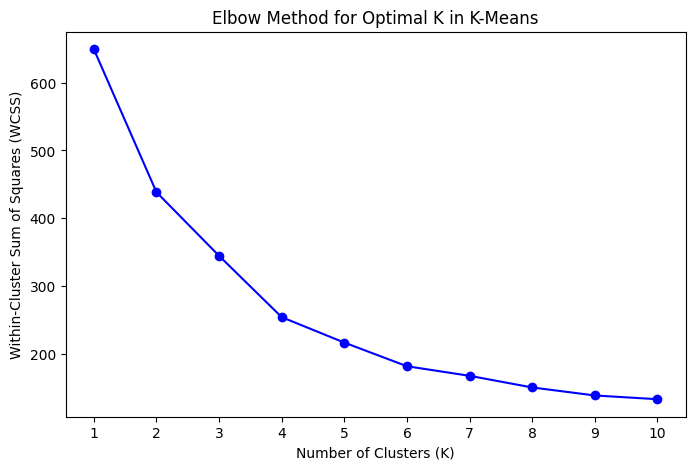

In [7]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(processed_data_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal K in K-Means")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_range)
plt.show()

# K-Means and DBSCAN Clustering

In [8]:
# Define number of clusters based on Elbow (usually 5 for this dataset)
n_clusters = 5

# Apply K-Means
kmeans = KMeans(n_clusters=n_clusters, max_iter=30, random_state=42, n_init=10)
processed_data_df['KMeans_Cluster'] = kmeans.fit_predict(processed_data_df)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
processed_data_df['DBSCAN_Cluster'] = dbscan.fit_predict(processed_data_df.drop(columns=['KMeans_Cluster']))

# Evaluation Scores
data_only = processed_data_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster'])

s_kmeans = silhouette_score(data_only, processed_data_df['KMeans_Cluster'])
s_dbscan = silhouette_score(data_only, processed_data_df['DBSCAN_Cluster'])
dbi_kmeans = davies_bouldin_score(data_only, processed_data_df['KMeans_Cluster'])
dbi_dbscan = davies_bouldin_score(data_only, processed_data_df['DBSCAN_Cluster'])

print(f"Silhouette Score (K-Means): {s_kmeans}")
print(f"Silhouette Score (DBSCAN): {s_dbscan}")
print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans}")
print(f"Davies-Bouldin Index (DBSCAN): {dbi_dbscan}")

Silhouette Score (K-Means): 0.34977050035201074
Silhouette Score (DBSCAN): -0.011387465358068827
Davies-Bouldin Index (K-Means): 1.0245227921150648
Davies-Bouldin Index (DBSCAN): 1.5008184621600702


# PCA Visualization (K-Means & DBSCAN)

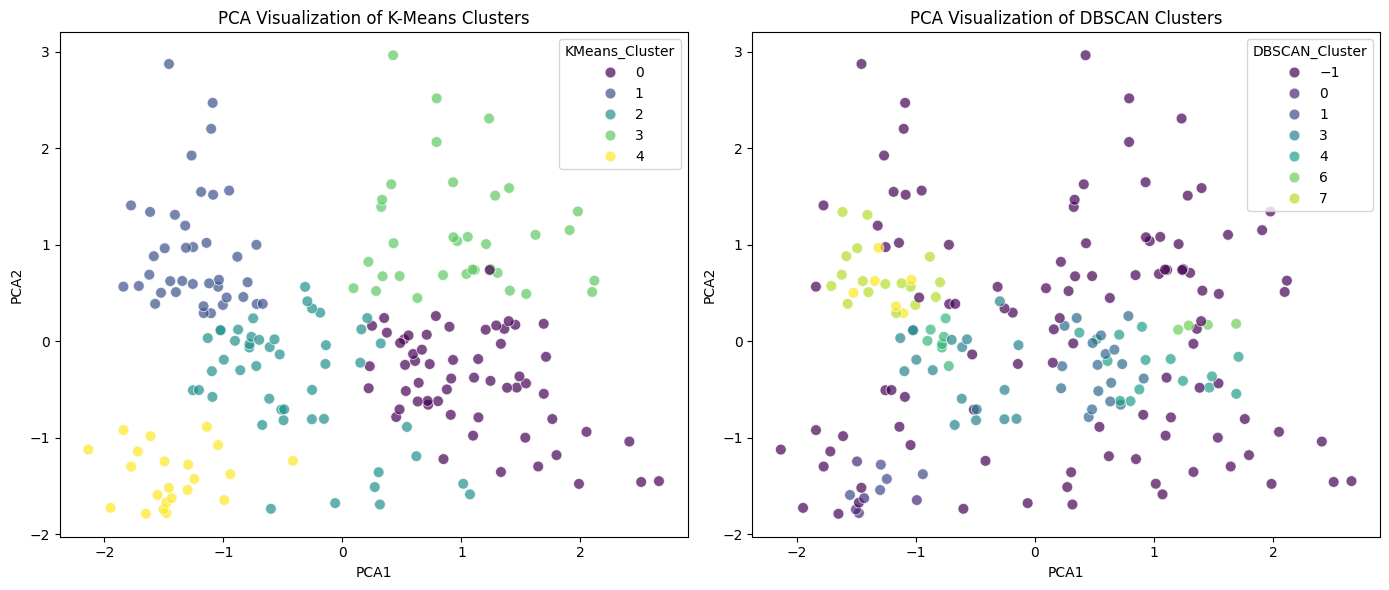

In [9]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(data_only)
processed_data_df['PCA1'] = pca_result[:, 0]
processed_data_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(14, 6))

# K-Means Plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("PCA Visualization of K-Means Clusters")

# DBSCAN Plot
plt.subplot(1, 2, 2)
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("PCA Visualization of DBSCAN Clusters")

plt.tight_layout()
plt.show()

# Gaussian Mixture Model (GMM)

Silhouette Score (GMM): 0.33231744771690586
Davies-Bouldin Index (GMM): 1.0383109124009209


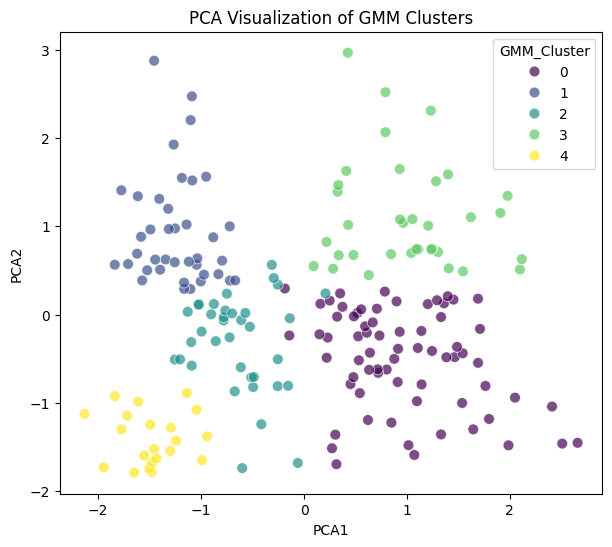

In [10]:
# Apply GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
processed_data_df['GMM_Cluster'] = gmm.fit_predict(data_only)

# Evaluation for GMM
s_gmm = silhouette_score(data_only, processed_data_df['GMM_Cluster'])
dbi_gmm = davies_bouldin_score(data_only, processed_data_df['GMM_Cluster'])

print(f"Silhouette Score (GMM): {s_gmm}")
print(f"Davies-Bouldin Index (GMM): {dbi_gmm}")

# PCA Visualization for GMM
plt.figure(figsize=(7, 6))
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("PCA Visualization of GMM Clusters")
plt.show()

# t-SNE Visualization

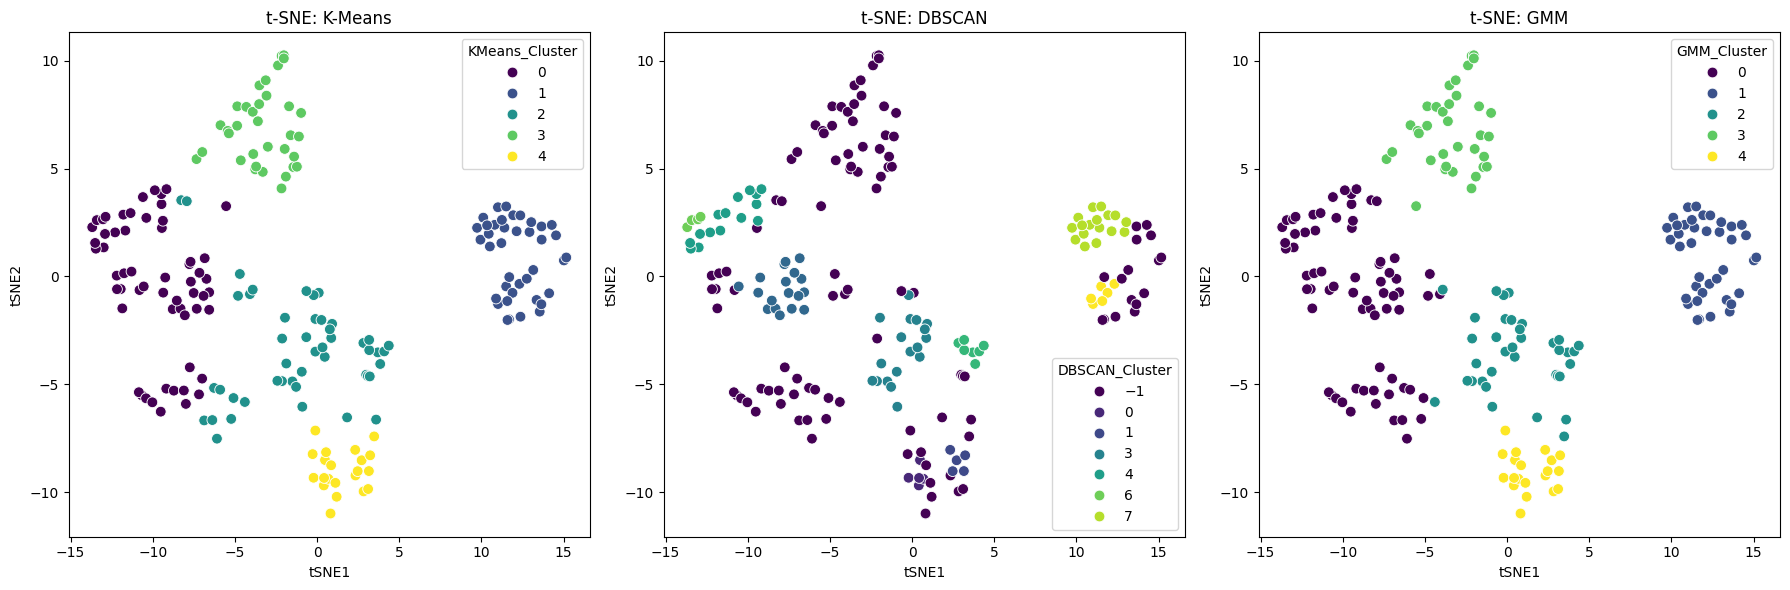

In [12]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_only)
processed_data_df['tSNE1'] = tsne_result[:, 0]
processed_data_df['tSNE2'] = tsne_result[:, 1]

# Plot t-SNE for all three
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=processed_data_df, x='tSNE1', y='tSNE2', hue='KMeans_Cluster', palette='viridis', s=60)
plt.title("t-SNE: K-Means")

plt.subplot(1, 3, 2)
sns.scatterplot(data=processed_data_df, x='tSNE1', y='tSNE2', hue='DBSCAN_Cluster', palette='viridis', s=60)
plt.title("t-SNE: DBSCAN")

plt.subplot(1, 3, 3)
sns.scatterplot(data=processed_data_df, x='tSNE1', y='tSNE2', hue='GMM_Cluster', palette='viridis', s=60)
plt.title("t-SNE: GMM")

plt.tight_layout()
plt.show()